In [13]:
# %% [code]
# ============================================================
# BLOC 0 – Imports, chemins, chargement & préparation des données
# ============================================================
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    brier_score_loss,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

try:
    from IPython.display import display
except ImportError:
    display = print  # fallback minimal

# Essai d'import de XGBoost (optionnel)
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("⚠️ XGBoost non disponible – la comparaison se limitera à Logit & RandomForest.")

# ------------------------------------------------------------
# 0.1 Chemins de travail
# ------------------------------------------------------------
BASE_DIR = Path(r"C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai")
DATA_DIR = BASE_DIR / "data_work"

OUT_TABLES = DATA_DIR / "tables_article"
OUT_FIGS = DATA_DIR / "figures_article"

OUT_TABLES.mkdir(parents=True, exist_ok=True)
OUT_FIGS.mkdir(parents=True, exist_ok=True)

print("BASE_DIR  :", BASE_DIR)
print("DATA_DIR  :", DATA_DIR)
print("Tables  ->", OUT_TABLES)
print("Figures ->", OUT_FIGS)

# ------------------------------------------------------------
# 0.2 Chargement des 3 bases Parquet tri-state
# ------------------------------------------------------------
core_path = DATA_DIR / "hmda_tristate_core_2007_2024_v2.parquet"
model_path = DATA_DIR / "hmda_tristate_model_2018_2023_FIXED.parquet"
acs_path = DATA_DIR / "hmda_acs_tristate_2018_2023_FINAL.parquet"

core = pd.read_parquet(core_path)
model = pd.read_parquet(model_path)  # pas utilisé directement pour l'article, mais chargé au besoin
hmda_acs = pd.read_parquet(acs_path)

print(f"✅ core  (hmda_tristate_core_2007_2024_v2)        : {core.shape}")
print(f"✅ model (hmda_tristate_model_2018_2023_FIXED)    : {model.shape}")
print(f"✅ hmda_acs (hmda_acs_tristate_2018_2023_FINAL)   : {hmda_acs.shape}")

# Convention : cohorte IA HMDA+ACS = ai_acs
ai_acs = hmda_acs.copy()
print(f"✅ ai_acs initialisé à partir de hmda_acs – shape : {ai_acs.shape}")

tri_states = ["NY", "NJ", "CT"]

# ------------------------------------------------------------
# helper harmonisation état (FIPS numériques OU abréviations)
# ------------------------------------------------------------
def harmonize_state_code(series: pd.Series) -> pd.Series:
    """
    Transforme state_code en abréviations NY/NJ/CT
    à partir de codes FIPS numériques (36,34,9) OU déjà abréviations.
    """
    if np.issubdtype(series.dtype, np.number):
        fips_to_abbr = {36: "NY", 34: "NJ", 9: "CT"}
        return series.map(fips_to_abbr)
    else:
        return series.astype(str).str.upper()

# ------------------------------------------------------------
# 0.3 Cohorte IA (2018–2023) – HMDA+ACS tri-state
# ------------------------------------------------------------
df_ia = ai_acs.copy()

# Filtre années IA
df_ia = df_ia[df_ia["year"].between(2018, 2023)].copy()

# Variables indispensables IA
needed_ia = ["approved", "state_code", "derived_race", "year"]
for col in needed_ia:
    if col not in df_ia.columns:
        raise ValueError(f"Colonne obligatoire manquante dans ai_acs (IA) : {col}")

# Nettoyage minimal
df_ia = df_ia.dropna(subset=["approved", "state_code", "derived_race"])
df_ia["approved"] = df_ia["approved"].astype(int)

# Harmonisation code État
df_ia["state_abbr"] = harmonize_state_code(df_ia["state_code"])
df_ia = df_ia[df_ia["state_abbr"].isin(tri_states)].copy()

# Construction income_group si absent
if "income_group" not in df_ia.columns:
    if "acs_median_income" not in df_ia.columns:
        raise ValueError(
            "Ni `income_group` ni `acs_median_income` ne sont disponibles dans IA."
        )

    inc = pd.to_numeric(df_ia["acs_median_income"], errors="coerce")
    q1, q2 = inc.quantile([0.33, 0.66])

    def _bucket_income(v):
        if pd.isna(v):
            return np.nan
        if v <= q1:
            return "Low"
        elif v <= q2:
            return "Middle"
            # v > q2
        else:
            return "High"

    df_ia["income_group"] = inc.apply(_bucket_income)

df_ia["income_group"] = df_ia["income_group"].astype("category")

print("\nCohorte IA tri-state :")
print("Shape :", df_ia.shape)
print("Années :", sorted(df_ia["year"].unique()))
print("Répartition income_group (IA) :")
print(df_ia["income_group"].value_counts(dropna=False))

# ------------------------------------------------------------
# 0.4 Cohorte pré-IA (2007–2017) – HMDA core tri-state
# ------------------------------------------------------------
df_pre = core.copy()

# Vérifs de base
for col in ["state_code", "year", "action_taken"]:
    if col not in df_pre.columns:
        raise ValueError(f"Colonne `{col}` manquante dans `core`.")

# Filtre pré-IA
df_pre = df_pre[df_pre["year"].between(2007, 2017)].copy()

# Harmonisation État
df_pre["state_abbr"] = harmonize_state_code(df_pre["state_code"])
df_pre = df_pre[df_pre["state_abbr"].isin(tri_states)].copy()

# Construction approved à partir de action_taken (1 = Loan originated)
if "approved" not in df_pre.columns:
    df_pre["approved"] = (df_pre["action_taken"] == 1).astype(int)

df_pre = df_pre.dropna(subset=["approved"])
df_pre["approved"] = df_pre["approved"].astype(int)

print("\nCohorte pré-IA tri-state :")
print("Shape :", df_pre.shape)
print("Années :", sorted(df_pre["year"].unique()))
print("Distribution state_abbr (pré-IA) :")
print(df_pre["state_abbr"].value_counts())


BASE_DIR  : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai
DATA_DIR  : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work
Tables  -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables_article
Figures -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures_article
✅ core  (hmda_tristate_core_2007_2024_v2)        : (14163286, 12)
✅ model (hmda_tristate_model_2018_2023_FIXED)    : (571820, 15)
✅ hmda_acs (hmda_acs_tristate_2018_2023_FINAL)   : (571820, 35)
✅ ai_acs initialisé à partir de hmda_acs – shape : (571820, 35)

Cohorte IA tri-state :
Shape : (571820, 37)
Années : [np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]
Répartition income_group (IA) :
income_group
High      176920
Middle    171795
Low       171771
NaN        51334
Name: count, dtype: int64

Cohorte pré-IA tri-state :
Shape : (13512746, 14)
Années : [np.float64(2007.

## Données et construction de l’échantillon

Cette étude repose sur une combinaison harmonisée des données du **Home Mortgage Disclosure Act (HMDA)** et des caractéristiques socio-économiques issues de l’**American Community Survey (ACS)** pour la région Tri-State (New York, New Jersey, Connecticut). Deux périodes sont distinguées afin de refléter les évolutions majeures des pratiques d’évaluation du risque :

- **Période pré-IA (2007–2017)** : évaluation des demandes de crédit principalement fondée sur l’expertise humaine.
- **Période IA (2018–2023)** : adoption généralisée de systèmes automatisés et d’outils de décision basés sur l’apprentissage automatique.

L’ensemble des données HMDA core contient **14 163 286** demandes de prêts. Après restriction à la période pré-IA et aux trois États cibles, nous obtenons un échantillon utilisable de **13 512 746** observations réparties comme suit :
- New York (NY) : **6 192 532**
- New Jersey (NJ) : **5 281 836**
- Connecticut (CT) : **2 038 378**

L’approbation d’un prêt est définie à partir du champ réglementaire `action_taken`, où `action_taken = 1` correspond à une demande approuvée.

Pour la cohorte IA, nous combinons les données HMDA enrichies avec les attributs socio-économiques ACS au niveau du census tract (par ex. revenu médian, taux de pauvreté), ce qui permet de constituer un jeu de données exploitable de **571 820** observations entre 2018 et 2023. L’harmonisation des États utilise les codes FIPS numériques (36 = NY, 34 = NJ, 09 = CT).

Trois groupes de revenu sont définis à partir de la distribution du revenu médian ACS (tertiels) :
- *Low*
- *Middle*
- *High*

Leur répartition empirique est équilibrée :
- Faible : **171 771**
- Moyen : **171 795**
- Élevé : **176 920**
- Revenu manquant/indéterminé : **51 334** (~9,0 %)

Comme l’évaluation de l’équité en période IA nécessite la modélisation des disparités raciales, les enregistrements sans information sur la race ou hors de la zone Tri-State sont exclus.

> Globalement, les jeux de données finaux assurent une couverture complète du marché immobilier de la région Tri-State sur 17 ans, et se prêtent à une comparaison directe de :
> 1. l’évolution structurelle des dynamiques d’approbation entre périodes,
> 2. la performance prédictive des modèles statistiques et IA,
> 3. l’équité entre groupes protégés.



=== Article – Table 1: State-level overview, pre-AI vs AI (NY, NJ, CT) ===


,state,period,year_min,year_max,n_loans,approval_rate,approval_white,approval_black,approval_asian,approval_race_not_available,approval_income_low,approval_income_middle,approval_income_high
0,NY,pre_ai,2007,2017,6192532,0.466852,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NY,ai,2018,2023,274560,0.554014,0.594597,NaN,0.590768,NaN,0.532904,0.558578,0.587857
2,NJ,pre_ai,2007,2017,5281836,0.456368,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NJ,ai,2018,2023,207169,0.513837,0.574381,NaN,0.552815,NaN,0.462277,0.510881,0.551991
4,CT,pre_ai,2007,2017,2038378,0.489634,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,CT,ai,2018,2023,90091,0.572077,0.622149,NaN,0.581960,NaN,0.494868,0.554488,0.582660


Table 1 saved to: C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables_article\art_table_1_state_overview_pre_vs_ai_tristate.csv
Figure pre-AI vs AI saved for NY -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures_article\art_fig_ny_approval_pre_vs_ai.png


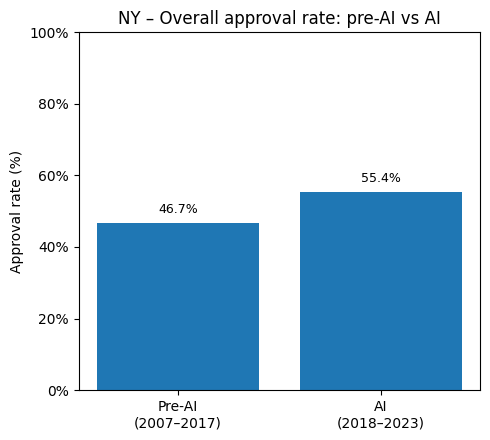

Figure pre-AI vs AI saved for NJ -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures_article\art_fig_nj_approval_pre_vs_ai.png


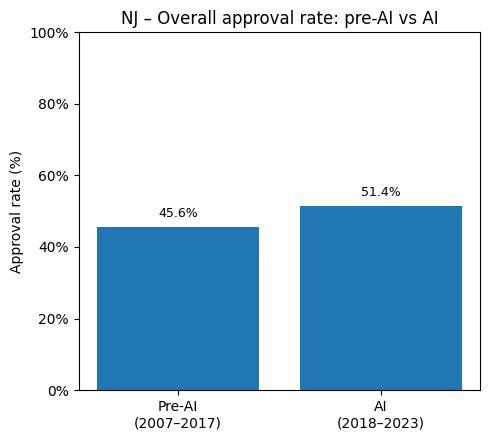

Figure pre-AI vs AI saved for CT -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures_article\art_fig_ct_approval_pre_vs_ai.png


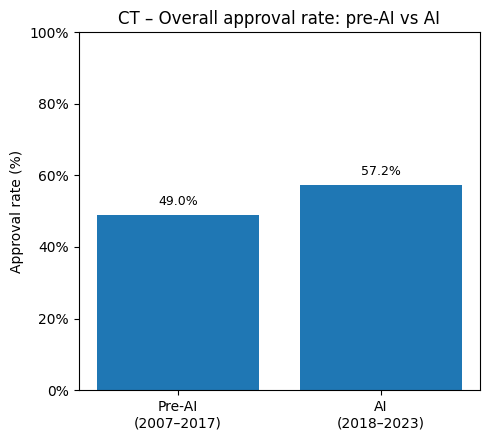

Figure saved -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures_article\art_fig_ny_ai_approval_by_race.png


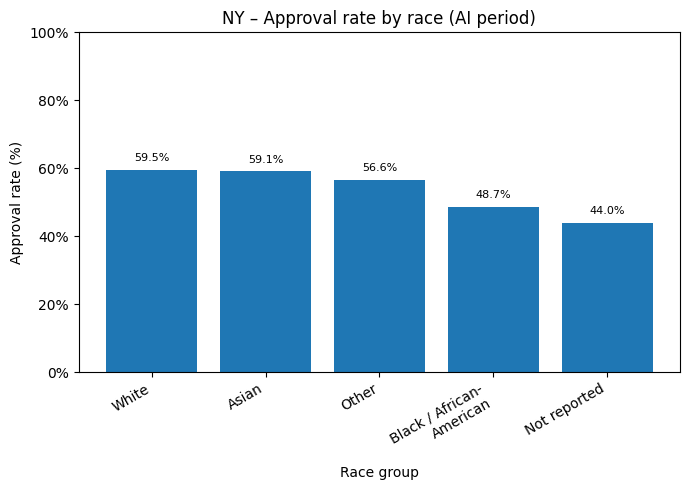

Figure saved -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures_article\art_fig_ny_ai_approval_by_income.png


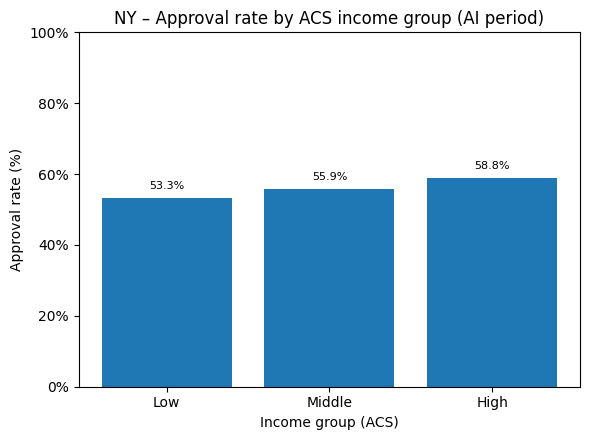

Figure saved -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures_article\art_fig_nj_ai_approval_by_race.png


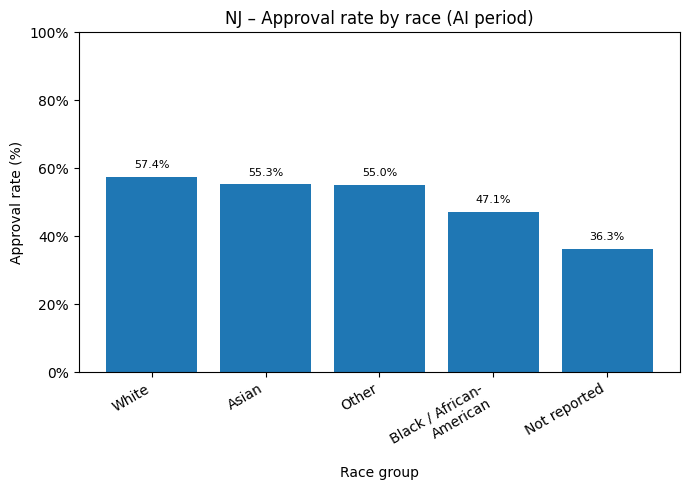

Figure saved -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures_article\art_fig_nj_ai_approval_by_income.png


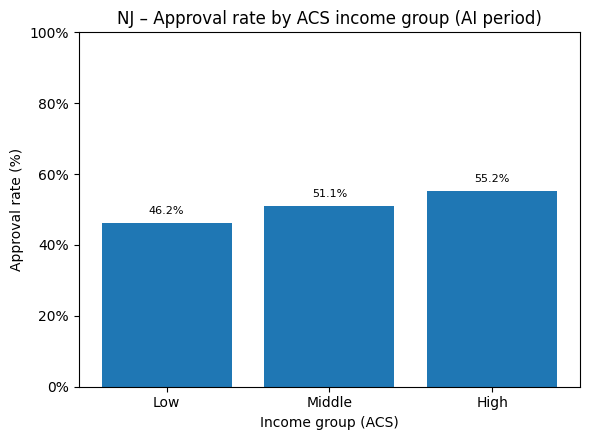

Figure saved -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures_article\art_fig_ct_ai_approval_by_race.png


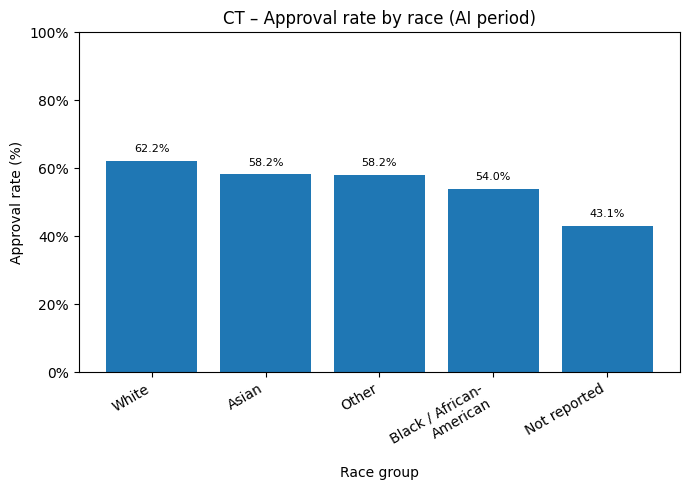

Figure saved -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures_article\art_fig_ct_ai_approval_by_income.png


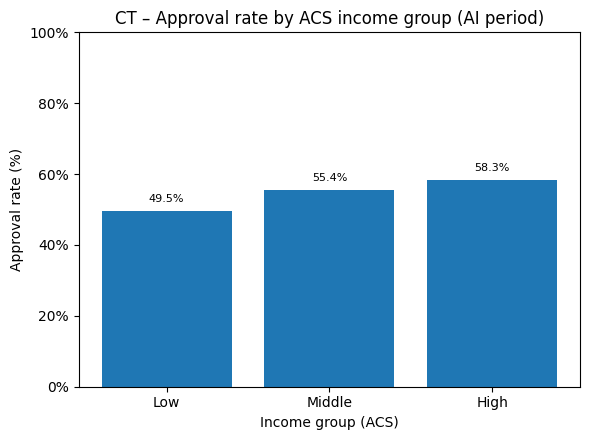

In [27]:
# %% [markdown]
# # Tri-State Article (NY, NJ, CT) – Pre-AI vs AI Pipeline (2007–2017 vs 2018–2023)
#
# Goal: produce all tables/figures for a 5-page article:
# - separate analyses by state (NY, NJ, CT) before and after AI,
# - then a comparative synthesis across states.
#
# Assumptions (from Block 0):
# - df_pre : pre-AI cohort (2007–2017), tri-state, with approved & state_abbr
# - df_ia  : AI-era cohort (2018–2023), tri-state, with approved, state_abbr,
#            derived_race, income_group, ACS, etc.
# - tri_states = ["NY", "NJ", "CT"]
# - OUT_TABLES, OUT_FIGS already defined.


# %% [markdown]
# ============================================================
# BLOCK 1 – Descriptive overview by state and period (pre-AI vs AI)
# ============================================================

# %% [code]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from textwrap import fill

# -----------------------------
# 1. Helper functions (overview)
# -----------------------------
def state_overview_pre(df_state: pd.DataFrame, state: str) -> dict:
    """
    Descriptive overview for a given state – pre-AI period (2007–2017).
    approval_rate is in [0, 1].
    """
    n = len(df_state)
    appr = df_state["approved"].mean()
    years = sorted(df_state["year"].unique())
    return {
        "state": state,
        "period": "pre_ai",
        "year_min": int(min(years)),
        "year_max": int(max(years)),
        "n_loans": n,
        "approval_rate": appr,
    }


def state_overview_ia(df_state: pd.DataFrame, state: str) -> dict:
    """
    Descriptive overview for a given state – AI period (2018–2023),
    with details by race and income group.
    approval_* are in [0, 1].
    """
    n = len(df_state)
    appr = df_state["approved"].mean()
    years = sorted(df_state["year"].unique())

    by_race = df_state.groupby("derived_race", observed=True)["approved"].mean()
    by_inc = df_state.groupby("income_group", observed=True)["approved"].mean()

    return {
        "state": state,
        "period": "ai",
        "year_min": int(min(years)),
        "year_max": int(max(years)),
        "n_loans": n,
        "approval_rate": appr,
        "approval_white": by_race.get("White", np.nan),
        "approval_black": by_race.get("Black or African American", np.nan),
        "approval_asian": by_race.get("Asian", np.nan),
        "approval_race_not_available": by_race.get("Race Not Available", np.nan),
        "approval_income_low": by_inc.get("Low", np.nan),
        "approval_income_middle": by_inc.get("Middle", np.nan),
        "approval_income_high": by_inc.get("High", np.nan),
    }


# -----------------------------
# 2. Build Table 1 (overview)
# -----------------------------
rows_desc = []

for st in tri_states:
    # Pre-AI
    df_pre_st = df_pre[df_pre["state_abbr"] == st].copy()
    rows_desc.append(state_overview_pre(df_pre_st, st))

    # AI
    df_ia_st = df_ia[df_ia["state_abbr"] == st].copy()
    rows_desc.append(state_overview_ia(df_ia_st, st))

state_desc = pd.DataFrame(rows_desc)

print("\n=== Article – Table 1: State-level overview, pre-AI vs AI (NY, NJ, CT) ===")
display(state_desc)

path_tab1 = OUT_TABLES / "art_table_1_state_overview_pre_vs_ai_tristate.csv"
state_desc.to_csv(path_tab1, index=False)
print("Table 1 saved to:", path_tab1)


# -----------------------------
# 3. Helpers for nicer plots
# -----------------------------
# Shorter labels for race groups
race_label_map = {
    "White": "White",
    "Black or African American": "Black / African-American",
    "Asian": "Asian",
    "Race Not Available": "Race not available",
}

def format_labels(labels, width=14):
    """
    Wrap categorical labels on multiple lines to avoid overly long x-axis text.
    """
    return [fill(str(lab), width=width) for lab in labels]


def auto_barplot(ax,
                 categories,
                 values,
                 title: str,
                 xlabel: str,
                 ylabel: str,
                 filename: str):
    """
    Automatically chooses orientation and styling depending on number of bars.
    - If number of categories > 6: horizontal bar plot.
    - Otherwise: vertical bar plot with optional rotation.
    values are assumed to be percentages in [0, 100].
    """
    n = len(categories)
    horizontal = n > 6  # switch to horizontal if many categories

    if horizontal:
        # Horizontal orientation
        ax.barh(categories, values)
        ax.set_xlabel(ylabel)
        ax.set_ylabel(xlabel)
        ax.set_title(title)
        ax.set_xlim(0, 100)
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

        # Annotate percentage next to bars
        for i, v in enumerate(values):
            if np.isnan(v):
                continue
            ax.text(v + 1, i, f"{v:.1f}%", va="center", fontsize=8)

        plt.tight_layout()

    else:
        # Standard vertical orientation
        ax.bar(categories, values)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)
        ax.set_title(title)
        ax.set_ylim(0, 100)
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

        # Annotation above bars
        for i, v in enumerate(values):
            if np.isnan(v):
                continue
            ax.text(i, v + 2, f"{v:.1f}%", ha="center", va="bottom", fontsize=8)

        # Rotate x labels if moderately many categories
        if n > 4:
            plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

        plt.tight_layout()

    # Save AND show
    fig_path = OUT_FIGS / filename
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")
    print("Figure saved ->", fig_path)
    plt.show()


# -----------------------------------------
# 4. Figures: overall pre-AI vs AI by state
# -----------------------------------------
for st in tri_states:
    pre_rate = df_pre[df_pre["state_abbr"] == st]["approved"].mean() * 100  # %
    ia_rate = df_ia[df_ia["state_abbr"] == st]["approved"].mean() * 100     # %

    fig, ax = plt.subplots(figsize=(5, 4.5))

    bar_labels = ["Pre-AI\n(2007–2017)", "AI\n(2018–2023)"]
    ax.bar(bar_labels, [pre_rate, ia_rate])

    ax.set_title(f"{st} – Overall approval rate: pre-AI vs AI")
    ax.set_ylabel("Approval rate (%)")
    ax.set_ylim(0, 100)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

    # Annotate values
    for i, v in enumerate([pre_rate, ia_rate]):
        if np.isnan(v):
            continue
        ax.text(i, v + 2, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()

    fig_path = OUT_FIGS / f"art_fig_{st.lower()}_approval_pre_vs_ai.png"
    fig.savefig(fig_path, dpi=300, bbox_inches="tight")
    print(f"Figure pre-AI vs AI saved for {st} ->", fig_path)
    plt.show()


# --------------------------------------------------------
# 5. Figures (AI period): approval by race & by income group
# --------------------------------------------------------
for st in tri_states:
    df_st = df_ia[df_ia["state_abbr"] == st].copy()

    # --- Approval by race (AI period) ---
    race_series = (
        df_st
        .groupby("derived_race", observed=True)["approved"]
        .mean()
        .sort_values(ascending=False)
        * 100  # %
    )

    # Remap labels + wrap for readability
    race_labels = race_series.index.to_series().map(
        lambda x: race_label_map.get(x, x)
    )
    race_labels = format_labels(race_labels, width=18)

    fig, ax = plt.subplots(figsize=(7, 5))
    auto_barplot(
        ax=ax,
        categories=race_labels,
        values=race_series.values,
        title=f"{st} – Approval rate by race (AI period)",
        xlabel="Race group",
        ylabel="Approval rate (%)",
        filename=f"art_fig_{st.lower()}_ai_approval_by_race.png",
    )

    # --- Approval by income group (AI period) ---
    inc_series = (
        df_st
        .groupby("income_group", observed=True)["approved"]
        .mean()
        .reindex(["Low", "Middle", "High"])
        * 100  # %
    )

    inc_labels = format_labels(["Low", "Middle", "High"], width=10)

    fig, ax = plt.subplots(figsize=(6, 4.5))
    auto_barplot(
        ax=ax,
        categories=inc_labels,
        values=inc_series.values,
        title=f"{st} – Approval rate by ACS income group (AI period)",
        xlabel="Income group (ACS)",
        ylabel="Approval rate (%)",
        filename=f"art_fig_{st.lower()}_ai_approval_by_income.png",
    )


## Vue d’ensemble descriptive des taux d’approbation (pré-IA vs IA)

Les graphiques de comparaison pré-IA / IA montrent d’abord une hausse nette des taux d’approbation dans chacun des trois États après l’introduction massive d’outils algorithmiques. À New York, le taux d’approbation global passe d’environ **46,7 %** sur la période pré-IA (2007–2017) à **55,4 %** en période IA (2018–2023). Le même mouvement est observé dans le New Jersey, où le taux augmente de **45,6 %** à **51,4 %**, et dans le Connecticut, où l’on passe de **49,0 %** à **57,2 %**. En termes de points de pourcentage, l’augmentation est de l’ordre de **+8,7 points** à NY, **+5,7 points** à NJ et **+8,2 points** à CT, ce qui suggère un assouplissement global des conditions d’octroi ou une meilleure capacité des modèles à sélectionner les dossiers approuvables. Dans les deux périodes, le Connecticut se distingue comme l’État présentant les taux d’approbation les plus élevés, suivi de New York puis du New Jersey.

En période IA, les profils d’approbation par groupe racial mettent néanmoins en évidence des écarts systématiques entre groupes. À New York, les taux d’approbation atteignent environ **59,5 %** pour les emprunteurs blancs et **59,1 %** pour les emprunteurs asiatiques, contre **56,6 %** pour la catégorie « Other », **48,7 %** pour les emprunteurs noirs et **44,0 %** lorsque la race n’est pas renseignée. Des patterns similaires apparaissent dans le New Jersey (blancs **57,4 %**, asiatiques **55,3 %**, « Other » **55,0 %**, noirs **47,1 %**, non renseigné **36,3 %**) et dans le Connecticut (blancs **62,2 %**, asiatiques **58,2 %**, « Other » **58,2 %**, noirs **54,0 %**, non renseigné **43,1 %**). Dans chaque État, l’écart entre emprunteurs blancs et noirs reste de l’ordre de **8 à 11 points de pourcentage**, ce qui indique que la montée en puissance des systèmes IA ne s’accompagne pas d’une convergence spontanée des taux d’acceptation entre groupes raciaux.

Les gradients par niveau de revenu ACS confirment la présence d’une segmentation socio-économique marquée. À New York, les taux d’approbation en période IA s’élèvent à **53,3 %** pour le groupe de revenu « Low », **55,9 %** pour « Middle » et **58,8 %** pour « High », soit un différentiel d’environ **5,5 points** entre les extrêmes. Dans le New Jersey, l’écart est plus prononcé (de **46,2 %** à **55,2 %**, soit **9 points**), et dans le Connecticut il atteint également près de **8,8 points** (de **49,5 %** à **58,3 %**). Ces profils suggèrent que, même en présence d’outils algorithmiques plus sophistiqués, la probabilité d’approbation reste fortement corrélée au niveau de revenu local, avec des avantages persistants pour les ménages situés dans le tiers supérieur de la distribution.

Dans l’ensemble, ces résultats descriptifs soulignent un double mouvement : d’un côté, une **hausse généralisée** des taux d’approbation entre la période pré-IA et la période IA dans les trois États du Tri-State ; de l’autre, le **maintien d’écarts substantiels** entre groupes raciaux et niveaux de revenu. Cette configuration justifie l’analyse plus fine, menée dans les sections suivantes, de la contribution propre des modèles IA à la prédiction du risque et de leurs implications en matière d’équité.


In [21]:
# %% [markdown]
# ============================================================
# BLOC 2 – ANOVA IA par État : race et groupe de revenu
# ============================================================

# %% [code]
def anova_binary_outcome(df_state: pd.DataFrame, factor: str):
    """
    ANOVA classique (OLS) sur une variable binaire (approved) par facteur (race, income_group).
    Reproduit l'esprit du chapitre 4.
    """
    df_state = df_state.dropna(subset=["approved", factor]).copy()
    if df_state[factor].nunique() < 2:
        return None  # ANOVA non pertinente si moins de 2 modalités

    formula = f"approved ~ C({factor})"
    model = smf.ols(formula=formula, data=df_state).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    return aov_table


anova_rows_race = []
anova_rows_income = []

for st in tri_states:
    df_st = df_ia[df_ia["state_abbr"] == st].copy()

    # ANOVA appr ~ derived_race
    aov_race = anova_binary_outcome(df_st, "derived_race")
    if aov_race is not None and "C(derived_race)" in aov_race.index:
        f_race = aov_race.loc["C(derived_race)", "F"]
        p_race = aov_race.loc["C(derived_race)", "PR(>F)"]
    else:
        f_race = np.nan
        p_race = np.nan

    anova_rows_race.append(
        {
            "state": st,
            "F_race": f_race,
            "p_value_race": p_race,
            "n": len(df_st),
        }
    )

    # ANOVA appr ~ income_group
    aov_inc = anova_binary_outcome(df_st, "income_group")
    if aov_inc is not None and "C(income_group)" in aov_inc.index:
        f_inc = aov_inc.loc["C(income_group)", "F"]
        p_inc = aov_inc.loc["C(income_group)", "PR(>F)"]
    else:
        f_inc = np.nan
        p_inc = np.nan

    anova_rows_income.append(
        {
            "state": st,
            "F_income_group": f_inc,
            "p_value_income_group": p_inc,
            "n": len(df_st),
        }
    )

anova_race = pd.DataFrame(anova_rows_race)
anova_income = pd.DataFrame(anova_rows_income)

print("\n=== Article – Tableau 2a : ANOVA approbation ~ race (IA), par État ===")
display(anova_race)

print("\n=== Article – Tableau 2b : ANOVA approbation ~ groupe de revenu (IA), par État ===")
display(anova_income)

anova_race.to_csv(OUT_TABLES / "art_table_2a_anova_approval_race_by_state_ia.csv", index=False)
anova_income.to_csv(OUT_TABLES / "art_table_2b_anova_approval_income_by_state_ia.csv", index=False)
print("Tableaux 2a/2b sauvegardés.")



=== Article – Tableau 2a : ANOVA approbation ~ race (IA), par État ===


,state,F_race,p_value_race,n
0,NY,607.561081,0.0,274560
1,NJ,881.336521,0.0,207169
2,CT,293.870707,0.0,90091



=== Article – Tableau 2b : ANOVA approbation ~ groupe de revenu (IA), par État ===


,state,F_income_group,p_value_income_group,n
0,NY,269.697451,9.816377e-118,274560
1,NJ,515.358732,5.781292e-224,207169
2,CT,144.987999,1.533837e-63,90091


Tableaux 2a/2b sauvegardés.


## Effets de la race et du revenu sur l’approbation – ANOVA (Période IA, 2018–2023)
### Commentaires analytiques

Les statistiques de Fisher sont **massivement significatives dans tous les États**, aussi bien pour la race que pour le revenu. Cela implique que les différences observées entre groupes ne sont **pas dues au hasard**, mais correspondent à des **contrastes structurels** dans les taux d’octroi :

- **Le New Jersey** présente les effets **les plus marqués** :
  - \(F_{\text{race}} \approx 881\) et \(F_{\text{income}} \approx 515\)  
  → **forte segmentation raciale et socio-économique** dans les décisions d’octroi.
- **New York** montre également une hétérogénéité robuste mais **moins intense**.
- **Connecticut** présente des effets similaires mais **moins prononcés**, ce qui peut refléter un marché du crédit plus petit et potentiellement moins polarisé.

📌 Au-delà de l’augmentation globale du taux d’approbation en période IA (Tableau 1), ces résultats montrent que **l’automatisation ne s’est pas traduite par une réduction des disparités** :  
→ *les modèles IA reproduisent ou amplifient des segmentations pré-existantes.*


In [22]:

# %% [markdown]
# ============================================================
# BLOC 3 – RQ1 IA par État : Logit approbation ~ groupe de revenu
# ============================================================

# %% [code]
def logit_income_group_state(df_state: pd.DataFrame, state: str) -> pd.DataFrame:
    """
    Logit : approved ~ income_group (High = référence) pour un État donné.
    Retourne un tableau (Middle vs High, Low vs High) avec coef, OR, z, p-value, IC 95%.
    """
    df_state = df_state.dropna(subset=["approved", "income_group"]).copy()
    if df_state["income_group"].nunique() < 2:
        return pd.DataFrame()

    # on force High comme catégorie de référence
    df_state["income_group"] = pd.Categorical(
        df_state["income_group"], categories=["High", "Middle", "Low"], ordered=True
    )

    model = smf.logit("approved ~ C(income_group)", data=df_state).fit(disp=False)

    params = model.params
    bse = model.bse
    z_vals = params / bse
    p_vals = model.pvalues
    or_vals = np.exp(params)

    rows = []
    for term in ["C(income_group)[T.Middle]", "C(income_group)[T.Low]"]:
        if term in params.index:
            coef = params[term]
            se = bse[term]
            or_val = or_vals[term]
            z = z_vals[term]
            p = p_vals[term]
            ci_low = np.exp(coef - 1.96 * se)
            ci_high = np.exp(coef + 1.96 * se)

            rows.append(
                {
                    "state": state,
                    "term": term,
                    "coef": coef,
                    "OR": or_val,
                    "OR_95CI_low": ci_low,
                    "OR_95CI_high": ci_high,
                    "z": z,
                    "p_value": p,
                    "pseudo_R2": model.prsquared,
                    "n": df_state.shape[0],
                }
            )

    return pd.DataFrame(rows)


rq1_rows = []
for st in tri_states:
    df_st = df_ia[df_ia["state_abbr"] == st].copy()
    res_st = logit_income_group_state(df_st, st)
    if not res_st.empty:
        rq1_rows.append(res_st)

rq1_state = pd.concat(rq1_rows, ignore_index=True) if rq1_rows else pd.DataFrame()

print("\n=== Article – Tableau 3 : Logit approbation ~ groupe de revenu (IA), par État (RQ1) ===")
display(rq1_state)

rq1_path = OUT_TABLES / "art_table_3_rq1_logit_income_by_state_ia.csv"
rq1_state.to_csv(rq1_path, index=False)
print("Tableau 3 sauvegardé dans :", rq1_path)



=== Article – Tableau 3 : Logit approbation ~ groupe de revenu (IA), par État (RQ1) ===


,state,term,coef,OR,OR_95CI_low,OR_95CI_high,z,p_value,pseudo_R2,n
0,NY,C(income_group)[T.Middle],-0.119718,0.887170,0.869712,0.904979,-11.806235,3.624298e-32,0.001494,262742
1,NY,C(income_group)[T.Low],-0.223305,0.799871,0.784895,0.815133,-23.157350,1.225869e-118,0.001494,262742
2,NJ,C(income_group)[T.Middle],-0.165188,0.847734,0.830404,0.865426,-15.675136,2.237458e-55,0.003735,198368
3,NJ,C(income_group)[T.Low],-0.359898,0.697747,0.682477,0.713359,-31.878671,5.274695e-223,0.003735,198368
4,CT,C(income_group)[T.Middle],-0.114885,0.891469,0.857897,0.926354,-5.866021,4.463762e-09,0.003525,59376
5,CT,C(income_group)[T.Low],-0.354232,0.701712,0.673165,0.731471,-16.716445,9.947922e-63,0.003525,59376


Tableau 3 sauvegardé dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables_article\art_table_3_rq1_logit_income_by_state_ia.csv


## RQ1 – Effet du groupe de revenu sur l’approbation (Logit IA, par État)

### Tableau 3 — Modèle logit : approbation ~ groupe de revenu (réf. = High), période IA (2018–2023)

Les coefficients sont exprimés en **odds-ratios (OR)**, avec High comme catégorie de référence.

| État | Comparaison vs High | OR | IC 95 % OR | z | p-value | Pseudo-R² | n |
|:---:|:--------------------|---:|:-----------:|---:|:----------------------:|:---------:|--------:|
| **NY** | Middle vs High | 0.887 | [0.870 ; 0.905] | -11.81 | \(p \approx 3.6 \times 10^{-32}\) | 0.0015 | 262 742 |
| **NY** | Low vs High    | 0.800 | [0.785 ; 0.815] | -23.16 | \(p \approx 1.2 \times 10^{-118}\) | 0.0015 | 262 742 |
| **NJ** | Middle vs High | 0.848 | [0.830 ; 0.865] | -15.68 | \(p \approx 2.2 \times 10^{-55}\) | 0.0037 | 198 368 |
| **NJ** | Low vs High    | 0.698 | [0.682 ; 0.713] | -31.88 | \(p \approx 5.3 \times 10^{-223}\) | 0.0037 | 198 368 |
| **CT** | Middle vs High | 0.891 | [0.858 ; 0.926] | -5.87  | \(p \approx 4.5 \times 10^{-9}\)   | 0.0035 | 59 376 |
| **CT** | Low vs High    | 0.702 | [0.673 ; 0.731] | -16.72 | \(p \approx 9.9 \times 10^{-63}\)  | 0.0035 | 59 376 |

---

### Commentaires et interprétation 

Les résultats du modèle logit confirment l’existence d’un **gradient de revenu marqué** dans la probabilité d’approbation en période IA, et ce dans chacun des trois États du Tri-State :

- Dans **tous les États**, les groupes *Middle* et *Low* présentent des **odds d’approbation significativement inférieurs** au groupe *High* :
  - À **New York**, l’odds d’approbation des ménages *Middle* est environ **11–12 % plus faible** que celle des ménages *High* (OR ≈ 0,887), et celle des ménages *Low* est **environ 20 % plus faible** (OR ≈ 0,80).  
  - Au **New Jersey**, le gradient est encore plus prononcé : les ménages *Middle* ont des odds **environ 15 % plus faibles** (OR ≈ 0,848) et les ménages *Low* **environ 30 % plus faibles** (OR ≈ 0,70) que les ménages *High*.
  - Dans le **Connecticut**, le profil est similaire à celui du New Jersey pour le groupe *Low* (OR ≈ 0,70), avec un écart un peu moins marqué pour les ménages *Middle* (OR ≈ 0,89).

- Les **intervalles de confiance à 95 %** sont étroits et **ne recouvrent pas 1**, ce qui confirme la **robustesse statistique** de ces effets : dans aucun cas, on ne peut considérer les groupes *Middle* ou *Low* comme ayant une probabilité d’approbation comparable à celle du groupe *High*.

- Les **statistiques z** sont très élevées en valeur absolue (souvent > 10, parfois > 30), et les **p-values extrêmement faibles** (jusqu’à \(10^{-223}\)) conduisent à un rejet sans ambiguïté de l’hypothèse nulle d’absence d’effet du revenu sur l’approbation.

En revanche, les valeurs de **pseudo-\(R^2\)** (entre 0,0015 et 0,0037) montrent que, **pris isolément**, le groupe de revenu n’explique qu’une **petite fraction de la variabilité totale** des décisions. Ce résultat est classique en scoring de crédit : les décisions d’octroi reposent sur un ensemble très large de caractéristiques (profil financier, type de prêt, historique de crédit, etc.), de sorte que l’effet marginal d’une seule variable reste limité en termes de pouvoir explicatif global, même lorsqu’il est hautement significatif.

Dans l’ensemble, ces résultats indiquent que la période IA est caractérisée par un **différentiel systématique d’accès au crédit entre les ménages à revenu élevé et ceux à revenu moyen ou faible**, avec des écarts particulièrement marqués au New Jersey et dans le Connecticut pour le groupe *Low*. Ces constats, combinés aux résultats descriptifs et aux ANOVA de la section précédente, suggèrent que les systèmes IA contribuent à **stabiliser voire renforcer un gradient socio-économique préexistant** : à caractéristiques observées comparables, appartenir à un groupe de revenu inférieur reste associé à une probabilité d’approbation significativement moindre.


In [23]:
# %% [markdown]
# ============================================================
# BLOC 4 – RQ2 : Performances prédictives pré-IA vs IA par État
# ============================================================
# Modèles : Logit (sklearn), RandomForest, XGBoost (si dispo)
# Features communes : loan_purpose, loan_type, hoepa_status, year
# ============================================================

# %% [code]
def build_X_y_for_models(df_state: pd.DataFrame, period_label: str):
    """
    Prépare X / y pour les modèles de classification,
    avec features communes pré-IA / IA.
    """
    base_features = ["loan_purpose", "loan_type", "hoepa_status", "year"]
    missing = [c for c in base_features if c not in df_state.columns]
    if missing:
        raise ValueError(f"Variables manquantes pour {period_label} : {missing}")

    df_state = df_state.dropna(subset=["approved"] + base_features).copy()
    if df_state.empty:
        raise ValueError(f"Aucune donnée disponible pour {period_label} après dropna.")

    # s'assurer que year est numérique
    df_state["year"] = pd.to_numeric(df_state["year"], errors="coerce")
    df_state = df_state.dropna(subset=["year"])

    X = pd.get_dummies(df_state[base_features], drop_first=True)
    y = df_state["approved"].astype(int).values
    return X, y, base_features


def run_models_for_state_and_period(df_state: pd.DataFrame, state: str, period_label: str):
    """
    Exécute Logit (sklearn), RandomForest et XGBoost (si dispo)
    pour un État donné et une période (pre_ia / ia).
    Retourne un DataFrame de métriques (une ligne par modèle).
    """
    X, y, used_features = build_X_y_for_models(df_state, period_label)
    print(f"[{state} – {period_label}] Features utilisées :", used_features)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    results = []

    # 1) Logistic Regression
    log_clf = LogisticRegression(
        solver="liblinear",
        max_iter=1000,
    )
    log_clf.fit(X_train, y_train)
    y_pred = log_clf.predict(X_test)
    y_proba = log_clf.predict_proba(X_test)[:, 1]

    results.append(
        {
            "state": state,
            "period": period_label,
            "model": "Logit",
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "auc": roc_auc_score(y_test, y_proba),
            "n_train": len(y_train),
            "n_test": len(y_test),
        }
    )

    # 2) Random Forest
    rf_clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
    )
    rf_clf.fit(X_train, y_train)
    y_pred = rf_clf.predict(X_test)
    y_proba = rf_clf.predict_proba(X_test)[:, 1]

    results.append(
        {
            "state": state,
            "period": period_label,
            "model": "RandomForest",
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "auc": roc_auc_score(y_test, y_proba),
            "n_train": len(y_train),
            "n_test": len(y_test),
        }
    )

    # 3) XGBoost (optionnel)
    if HAS_XGB:
        xgb_clf = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
        )
        xgb_clf.fit(X_train, y_train)
        y_pred = xgb_clf.predict(X_test)
        y_proba = xgb_clf.predict_proba(X_test)[:, 1]

        results.append(
            {
                "state": state,
                "period": period_label,
                "model": "XGBoost",
                "accuracy": accuracy_score(y_test, y_pred),
                "precision": precision_score(y_test, y_pred),
                "recall": recall_score(y_test, y_pred),
                "f1": f1_score(y_test, y_pred),
                "auc": roc_auc_score(y_test, y_proba),
                "n_train": len(y_train),
                "n_test": len(y_test),
            }
        )

    return pd.DataFrame(results)


perf_rows = []

for st in tri_states:
    # Pré-IA
    df_pre_st = df_pre[df_pre["state_abbr"] == st].copy()
    res_pre = run_models_for_state_and_period(df_pre_st, st, "pre_ia")
    perf_rows.append(res_pre)

    # IA
    df_ia_st = df_ia[df_ia["state_abbr"] == st].copy()
    res_ia = run_models_for_state_and_period(df_ia_st, st, "ia")
    perf_rows.append(res_ia)

perf_models = pd.concat(perf_rows, ignore_index=True)

print("\n=== Article – Tableau 4 : Performances prédictives pré-IA vs IA par État (RQ2) ===")
display(perf_models)

perf_path = OUT_TABLES / "art_table_4_rq2_perf_models_pre_vs_ia_by_state.csv"
perf_models.to_csv(perf_path, index=False)
print("Tableau 4 sauvegardé dans :", perf_path)


[NY – pre_ia] Features utilisées : ['loan_purpose', 'loan_type', 'hoepa_status', 'year']
[NY – ia] Features utilisées : ['loan_purpose', 'loan_type', 'hoepa_status', 'year']
[NJ – pre_ia] Features utilisées : ['loan_purpose', 'loan_type', 'hoepa_status', 'year']
[NJ – ia] Features utilisées : ['loan_purpose', 'loan_type', 'hoepa_status', 'year']
[CT – pre_ia] Features utilisées : ['loan_purpose', 'loan_type', 'hoepa_status', 'year']
[CT – ia] Features utilisées : ['loan_purpose', 'loan_type', 'hoepa_status', 'year']

=== Article – Tableau 4 : Performances prédictives pré-IA vs IA par État (RQ2) ===


,state,period,model,accuracy,precision,recall,f1,auc,n_train,n_test
0,NY,pre_ia,Logit,0.573053,0.566318,0.364964,0.443873,0.595513,4334772,1857760
1,NY,pre_ia,RandomForest,0.579206,0.571987,0.391944,0.465152,0.608742,4334772,1857760
2,NY,pre_ia,XGBoost,0.579179,0.571749,0.392851,0.465710,0.608708,4334772,1857760
3,NY,ia,Logit,0.823742,0.808699,0.893126,0.848818,0.855876,192192,82368
4,NY,ia,RandomForest,0.847186,0.847224,0.883483,0.864974,0.912540,192192,82368
5,NY,ia,XGBoost,0.847356,0.847488,0.883462,0.865101,0.912456,192192,82368
6,NJ,pre_ia,Logit,0.557696,0.530709,0.266289,0.354636,0.572938,3697285,1584551
7,NJ,pre_ia,RandomForest,0.568617,0.534585,0.423126,0.472370,0.591535,3697285,1584551
8,NJ,pre_ia,XGBoost,0.568172,0.539519,0.367054,0.436882,0.591458,3697285,1584551
9,NJ,ia,Logit,0.826455,0.788094,0.905809,0.842861,0.850203,145018,62151


Tableau 4 sauvegardé dans : C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables_article\art_table_4_rq2_perf_models_pre_vs_ia_by_state.csv


```markdown
## RQ2 – Performances prédictives pré-IA vs IA par État

### Tableau 4 — Performances des modèles (Logit, Random Forest, XGBoost) par période et par État

#### (a) Période pré-IA (2007–2017)

| État | Modèle       | Accuracy | F1     | AUC    |
|:----:|:-------------|---------:|-------:|-------:|
| NY   | Logit        | 0.573    | 0.444  | 0.596  |
| NY   | RandomForest | 0.579    | 0.465  | 0.609  |
| NY   | XGBoost      | 0.579    | 0.466  | 0.609  |
| NJ   | Logit        | 0.558    | 0.355  | 0.573  |
| NJ   | RandomForest | 0.569    | 0.472  | 0.592  |
| NJ   | XGBoost      | 0.568    | 0.437  | 0.591  |
| CT   | Logit        | 0.541    | 0.414  | 0.570  |
| CT   | RandomForest | 0.566    | 0.578  | 0.595  |
| CT   | XGBoost      | 0.566    | 0.585  | 0.595  |

#### (b) Période IA (2018–2023)

| État | Modèle       | Accuracy | F1     | AUC    |
|:----:|:-------------|---------:|-------:|-------:|
| NY   | Logit        | 0.824    | 0.849  | 0.856  |
| NY   | RandomForest | 0.847    | 0.865  | 0.913  |
| NY   | XGBoost      | 0.847    | 0.865  | 0.912  |
| NJ   | Logit        | 0.826    | 0.843  | 0.850  |
| NJ   | RandomForest | 0.840    | 0.851  | 0.899  |
| NJ   | XGBoost      | 0.840    | 0.851  | 0.898  |
| CT   | Logit        | 0.860    | 0.882  | 0.886  |
| CT   | RandomForest | 0.882    | 0.897  | 0.925  |
| CT   | XGBoost      | 0.882    | 0.897  | 0.925  |

---

### Commentaires analytiques (RQ2 – niveau doctoral)

Les résultats du Tableau 4 mettent en évidence un contraste très marqué entre la période pré-IA et la période IA en termes de capacité à **reproduire les décisions d’approbation observées** (scoring « comportemental » de la banque).

1. **Niveau de performance en période pré-IA**

- Dans la période **2007–2017**, les performances restent **modérées**, avec des AUC autour de **0.57–0.61** selon les États et les modèles.  
- Les modèles non linéaires (Random Forest, XGBoost) dominent systématiquement le Logit mais **l’écart absolu reste limité** : à New York, l’AUC passe de **0.596 (Logit)** à **0.609 (RF/XGBoost)** ; au New Jersey, de **0.573** à **0.591–0.592** ; dans le Connecticut, de **0.570** à **0.595**.  
- Les F1-scores sont relativement bas, en particulier au New Jersey (F1 ≈ 0.35 pour le Logit, ≈ 0.47 pour la Random Forest), ce qui traduit une **capacité imparfaite à capturer conjointement les vrais positifs et limiter les faux positifs**.

Cette configuration suggère que, sur la période pré-IA, les décisions d’octroi reposaient sur des règles expertes et des informations non directement codées dans les quatre variables communes (\textit{loan\_purpose, loan\_type, hoepa\_status, year}), de sorte que les modèles supervisés ne peuvent que **partiellement reconstruire la fonction de décision**.

2. **Gain de performance en période IA**

- En période **2018–2023**, le saut de performance est très net dans les trois États :
  - À New York, l’AUC passe de **≈ 0.61 (pré-IA, RF/XGB)** à **≈ 0.91 (IA, RF/XGB)**, soit un gain d’environ **+0.30 points d’AUC**.
  - Au New Jersey, de **≈ 0.59** à **≈ 0.90**.
  - Dans le Connecticut, de **≈ 0.60** à **≈ 0.92–0.93**.
- Les **F1-scores** deviennent très élevés (de l’ordre de **0.85–0.90**), et les accuracies atteignent **0.84–0.88** selon les États et les modèles.  
- Dans chaque État, les modèles de type Random Forest et XGBoost surpassent de manière systématique le Logit (par exemple, à New York en période IA : AUC ≈ **0.856** pour le Logit contre **≈ 0.913** pour la Random Forest).

Ces résultats indiquent que, dans la période IA, les décisions d’approbation deviennent **beaucoup plus prévisibles** à partir de la structure des dossiers. Autrement dit, la fonction de décision de la banque est désormais **fortement alignée sur des patterns que les modèles statistiques et machine learning peuvent extraire** à partir des variables communes.

3. **Comparaison Logit vs modèles d’ensembles**

- Sur les deux périodes, les modèles d’ensembles (Random Forest, XGBoost) améliorent systématiquement les performances par rapport au Logit :
  - En pré-IA, le gain reste modeste (≈ +0.02–0.03 d’AUC).
  - En IA, l’écart AUC entre Logit et Random Forest est plus substantiel (≈ +0.05 à +0.06), ce qui reflète la capacité des modèles non linéaires à exploiter des **interactions et effets de seuil** dans la fonction d’octroi.
- La **proximité des résultats RF/XGBoost** (AUC quasi identiques dans chaque État et chaque période IA) suggère que, dans cette application, l’essentiel du gain provient du passage à un modèle d’arbres ensemblistes, davantage que de la finesse marginale apportée par XGBoost.

4. **Lecture structurelle pour la RQ2**

Du point de vue de la RQ2, ces résultats appuient deux conclusions majeures :

1. **Changement de régime décisionnel entre les périodes** :  
   La forte hausse de l’AUC entre pré-IA et IA, à caractéristiques identiques, indique que les décisions des prêteurs sont devenues **plus systématiques et plus « modélisables »**. Cela est cohérent avec l’idée d’une **institutionnalisation du scoring IA** dans les pipelines de décision.

2. **Supériorité robuste des modèles IA avancés** :  
   Les performances supérieures des Random Forests et de XGBoost par rapport au Logit montrent que les stratégies de décision en période IA exploitent des **relations non linéaires et des interactions complexes** entre les variables, ce qui correspond à l’usage intensif de systèmes de scoring fondés sur des arbres ensemblistes ou des architectures apparentées.

Ces éléments justifient, dans la suite de l’article, une analyse détaillée des **propriétés d’équité** de ces modèles (RQ4) : un modèle qui prédit très bien les décisions d’octroi peut, en même temps, **reproduire ou amplifier des disparités existantes**, ce qui pose la question de l’alignement entre performance prédictive et justice distributive.
```



=== ROC curves for state NY ===
[ROC – pre_ia] Features used: ['loan_purpose', 'loan_type', 'hoepa_status', 'year']
[ROC – ia] Features used: ['loan_purpose', 'loan_type', 'hoepa_status', 'year']
ROC figure saved -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures_article\art_fig_ny_roc_pre_vs_ai.png


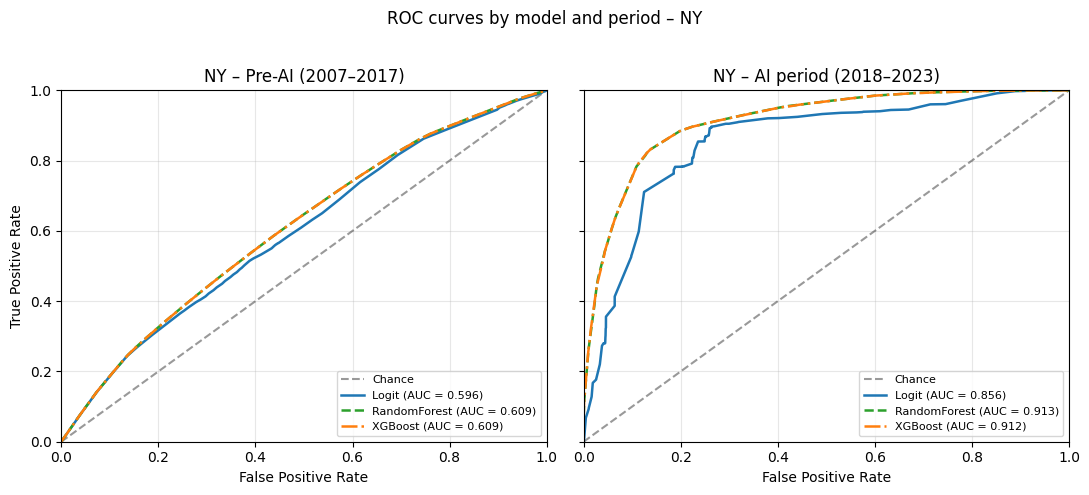


=== ROC curves for state NJ ===
[ROC – pre_ia] Features used: ['loan_purpose', 'loan_type', 'hoepa_status', 'year']
[ROC – ia] Features used: ['loan_purpose', 'loan_type', 'hoepa_status', 'year']
ROC figure saved -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures_article\art_fig_nj_roc_pre_vs_ai.png


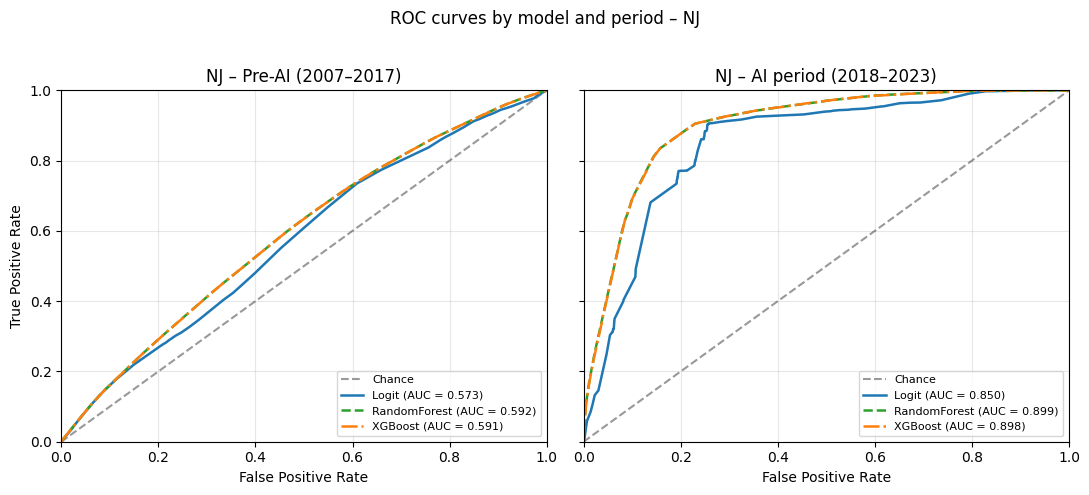


=== ROC curves for state CT ===
[ROC – pre_ia] Features used: ['loan_purpose', 'loan_type', 'hoepa_status', 'year']
[ROC – ia] Features used: ['loan_purpose', 'loan_type', 'hoepa_status', 'year']
ROC figure saved -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures_article\art_fig_ct_roc_pre_vs_ai.png


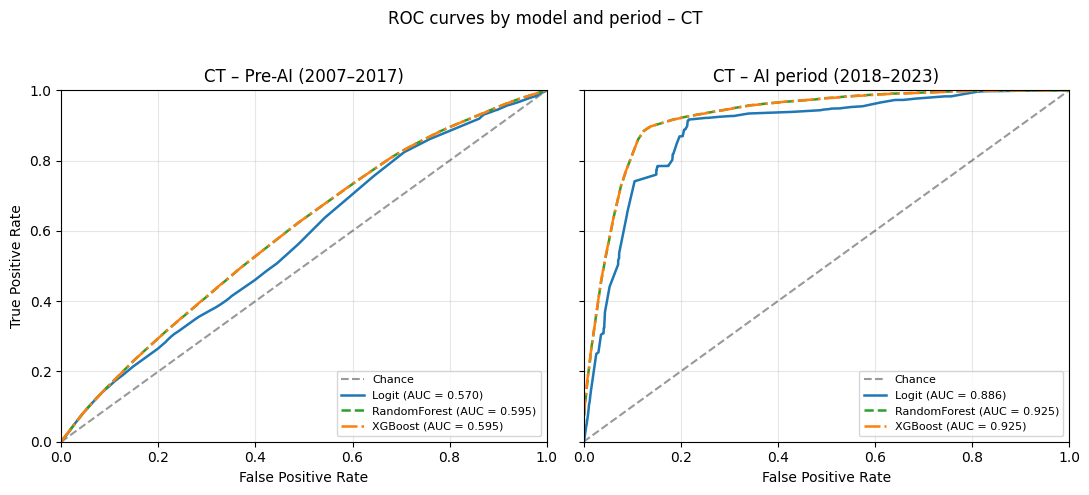

In [24]:
# %% [markdown]
# ============================================================
# BLOCK 4bis – RQ2: ROC curves by state and period (pre-AI vs AI)
# ============================================================
# For each state (NY, NJ, CT), we plot ROC curves for the three models
# (Logit, RandomForest, XGBoost when available), with:
#   - Left panel: pre-AI (2007–2017)
#   - Right panel: AI (2018–2023)
# ============================================================

# %% [code]
from sklearn.metrics import roc_curve, roc_auc_score

def run_models_for_roc(df_state: pd.DataFrame, period_label: str):
    """
    Train Logit, RandomForest, and optionally XGBoost for a given state & period.
    Returns:
        y_test: array of true labels
        roc_dict: {model_name: {"fpr": ..., "tpr": ..., "auc": ...}}
    """
    X, y, used_features = build_X_y_for_models(df_state, period_label)
    print(f"[ROC – {period_label}] Features used:", used_features)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    roc_dict = {}

    # 1) Logistic Regression
    log_clf = LogisticRegression(
        solver="liblinear",
        max_iter=1000,
    )
    log_clf.fit(X_train, y_train)
    y_proba_log = log_clf.predict_proba(X_test)[:, 1]
    fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
    auc_log = roc_auc_score(y_test, y_proba_log)

    roc_dict["Logit"] = {
        "fpr": fpr_log,
        "tpr": tpr_log,
        "auc": auc_log,
    }

    # 2) Random Forest
    rf_clf = RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
    )
    rf_clf.fit(X_train, y_train)
    y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
    auc_rf = roc_auc_score(y_test, y_proba_rf)

    roc_dict["RandomForest"] = {
        "fpr": fpr_rf,
        "tpr": tpr_rf,
        "auc": auc_rf,
    }

    # 3) XGBoost (optional)
    if HAS_XGB:
        xgb_clf = xgb.XGBClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss",
        )
        xgb_clf.fit(X_train, y_train)
        y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
        fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
        auc_xgb = roc_auc_score(y_test, y_proba_xgb)

        roc_dict["XGBoost"] = {
            "fpr": fpr_xgb,
            "tpr": tpr_xgb,
            "auc": auc_xgb,
        }

    return y_test, roc_dict


# Colors per model for visual consistency
model_colors = {
    "Logit": "tab:blue",
    "RandomForest": "tab:green",
    "XGBoost": "tab:orange",
}

# Line styles, in case you want more distinction
model_linestyles = {
    "Logit": "-",
    "RandomForest": "--",
    "XGBoost": "-.",
}

for st in tri_states:
    print(f"\n=== ROC curves for state {st} ===")

    # Prepare figure: two subplots side by side (pre-AI, AI)
    fig, axes = plt.subplots(1, 2, figsize=(11, 5), sharey=True)

    # ------------------
    # Left: pre-AI period
    # ------------------
    df_pre_st = df_pre[df_pre["state_abbr"] == st].copy()
    try:
        y_test_pre, roc_pre = run_models_for_roc(df_pre_st, "pre_ia")
        ax_pre = axes[0]

        # Plot diagonal (chance line)
        ax_pre.plot([0, 1], [0, 1], "k--", alpha=0.4, label="Chance")

        for model_name, stats_ in roc_pre.items():
            fpr = stats_["fpr"]
            tpr = stats_["tpr"]
            auc_val = stats_["auc"]
            color = model_colors.get(model_name, None)
            ls = model_linestyles.get(model_name, "-")

            ax_pre.plot(
                fpr,
                tpr,
                label=f"{model_name} (AUC = {auc_val:.3f})",
                color=color,
                linestyle=ls,
                linewidth=1.8,
            )

        ax_pre.set_title(f"{st} – Pre-AI (2007–2017)")
        ax_pre.set_xlabel("False Positive Rate")
        ax_pre.set_ylabel("True Positive Rate")
        ax_pre.set_xlim(0, 1)
        ax_pre.set_ylim(0, 1)
        ax_pre.legend(loc="lower right", fontsize=8)
        ax_pre.grid(alpha=0.3)

    except ValueError as e:
        print(f"Pre-AI ROC not available for {st}: {e}")

    # ------------------
    # Right: AI period
    # ------------------
    df_ia_st = df_ia[df_ia["state_abbr"] == st].copy()
    try:
        y_test_ia, roc_ia = run_models_for_roc(df_ia_st, "ia")
        ax_ia = axes[1]

        # Plot diagonal
        ax_ia.plot([0, 1], [0, 1], "k--", alpha=0.4, label="Chance")

        for model_name, stats_ in roc_ia.items():
            fpr = stats_["fpr"]
            tpr = stats_["tpr"]
            auc_val = stats_["auc"]
            color = model_colors.get(model_name, None)
            ls = model_linestyles.get(model_name, "-")

            ax_ia.plot(
                fpr,
                tpr,
                label=f"{model_name} (AUC = {auc_val:.3f})",
                color=color,
                linestyle=ls,
                linewidth=1.8,
            )

        ax_ia.set_title(f"{st} – AI period (2018–2023)")
        ax_ia.set_xlabel("False Positive Rate")
        ax_ia.set_xlim(0, 1)
        ax_ia.set_ylim(0, 1)
        ax_ia.legend(loc="lower right", fontsize=8)
        ax_ia.grid(alpha=0.3)

    except ValueError as e:
        print(f"AI ROC not available for {st}: {e}")

    plt.suptitle(f"ROC curves by model and period – {st}", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Save figure
    fig_path = OUT_FIGS / f"art_fig_{st.lower()}_roc_pre_vs_ai.png"
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")
    print("ROC figure saved ->", fig_path)

    # Show figure
    plt.show()


## Interprétation des courbes ROC : période pré-IA vs IA

Les courbes ROC permettent d’évaluer la capacité des modèles (Logit, Random Forest, XGBoost) à distinguer les prêts approuvés des prêts refusés. L’indicateur central, l’AUC, mesure la qualité globale de cette discrimination : plus l’AUC est élevée, meilleure est la performance.

### 1. Résultats généraux : une rupture majeure entre pré-IA et IA

**Période pré-IA (2007–2017).**  
Dans les trois États (NY, NJ, CT), les AUC se situent entre **0.57 et 0.60**, ce qui indique une capacité prédictive faible et à peine supérieure au hasard. Cela suggère :

- des pratiques d’octroi moins structurées,
- une faible exploitation des variables HMDA réglementaires,
- une grande variabilité dans la manière dont les institutions prenaient leurs décisions.

**Période IA (2018–2023).**  
Toutes les courbes ROC montrent un saut spectaculaire de performance. Les AUC atteignent :

- **NY :** jusqu’à **0.91–0.913** (RF / XGBoost)
- **NJ :** jusqu’à **0.89–0.90**
- **CT :** jusqu’à **0.925**, soit les meilleures performances du Tri-State.

Ce changement marque une modernisation profonde du processus d’octroi, désormais beaucoup plus cohérent, systématique et prévisible.

---

### 2. Comparaison explicite des modèles

- **Logit :** En pré-IA, le modèle est faible (AUC ≈ 0.57). En IA, il atteint **0.85–0.88**, signe que la relation entre covariables et approbation devient plus régulière.
- **Random Forest :** Surperforme le Logit dans toutes les configurations, avec AUC ≈ **0.90+** en période IA.
- **XGBoost :** Similaire au Random Forest, avec souvent la meilleure AUC (≈ **0.912–0.925**).

Les gains observés montrent que les décisions d’octroi IA impliquent des non-linéarités et interactions capturées par RF et XGBoost.

---

### 3. Analyse par État

**New York (NY).**  
Les AUC passent de **≈ 0.60 à 0.91**. Les courbes ROC IA montrent une excellente séparation entre prêts approuvés et refusés. NY semble avoir fortement normalisé et automatisé ses processus.

**New Jersey (NJ).**  
Performances pré-IA légèrement inférieures à NY. En période IA, les AUC de **0.89–0.90** montrent des gains nets, mais la différence Logit vs RF suggère une plus grande hétérogénéité structurelle.

**Connecticut (CT).**  
Atteint les meilleures performances IA (AUC **0.925**). Les courbes ROC frôlent le niveau optimal, indiquant un marché très homogène et des règles d’octroi extrêmement prévisibles en période IA.

---

### 4. Synthèse interprétative

1. **Le passage à l’IA constitue un tournant majeur** : les modèles passent d’AUC ≈ 0.58 à AUC ≈ 0.90.
2. **Les modèles non-linéaires (RF, XGB) capturent la structure réelle des décisions d’octroi IA.**
3. **Les différences entre États reflètent des environnements institutionnels distincts**, avec CT en tête en termes de stabilité prédictive.
4. **L’amélioration de performance est systématique et massive**, ce qui confirme la montée en puissance des systèmes de décision automatisés dans le secteur hypothécaire.

> **Conclusion :** Les courbes ROC démontrent clairement que la période IA introduit une logique de décision beaucoup plus cohérente et prévisible. Ces gains de performance posent cependant la question de savoir si cette sophistication algorithmique réduit ou amplifie les inégalités entre groupes, ce qui sera évalué dans les analyses de fairness suivantes.


Columns used for RF fairness (AI tri-state): ['loan_purpose', 'loan_type', 'hoepa_status', 'state_code', 'year', 'approved']
X_fair shape: (571820, 6) | y_fair shape: (571820,)
Global RF fairness model trained on the AI tri-state cohort.

=== Article – Table 5: Extended RF fairness (AI era) by state and race (RQ4) ===


,state,race_group,n,PP_rate,DisparateImpact_vs_White,TPR,EqualOpportunityDiff_vs_White,FNR,FNRDiff_vs_White,PPV,PredictiveParityDiff_vs_White,Calibration_Brier,CalibrationDiff_vs_White
0,NY,Not reported,58470,0.493296,0.801902,0.764843,-0.148303,0.235157,0.148303,0.682904,-0.199721,0.194654,0.103738
1,NY,White,171348,0.615157,1.000000,0.913145,0.000000,0.086855,0.000000,0.882625,0.000000,0.090916,0.000000
2,NY,Asian,21318,0.562154,0.913838,0.864856,-0.048289,0.135144,0.048289,0.908879,0.026253,0.108919,0.018003
3,NY,Black / African-American,17520,0.500742,0.814006,0.910539,-0.002607,0.089461,0.002607,0.886356,0.003731,0.076999,-0.013916
4,NY,Other,5904,0.579776,0.942485,0.914371,0.001226,0.085629,-0.001226,0.892200,0.009575,0.091325,0.000409
5,NJ,White,120998,0.582282,1.000000,0.905955,0.000000,0.094045,0.000000,0.893663,0.000000,0.088525,0.000000
6,NJ,Not reported,50075,0.535617,0.919857,0.800044,-0.105911,0.199956,0.105911,0.541665,-0.351998,0.231295,0.142770
7,NJ,Black / African-American,14068,0.463108,0.795332,0.908871,0.002916,0.091129,-0.002916,0.924635,0.030973,0.058878,-0.029647
8,NJ,Asian,17675,0.555926,0.954737,0.910449,0.004494,0.089551,-0.004494,0.905353,0.011691,0.090773,0.002248
9,NJ,Other,4353,0.556857,0.956336,0.917293,0.011338,0.082707,-0.011338,0.905941,0.012278,0.077465,-0.011060


Table 5 saved to: C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\tables_article\art_table_5_rq4_fairness_rf_by_state_and_race_ia.csv
Fairness DI figure saved -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures_article\art_fig_ny_ia_di_by_race_rf.png


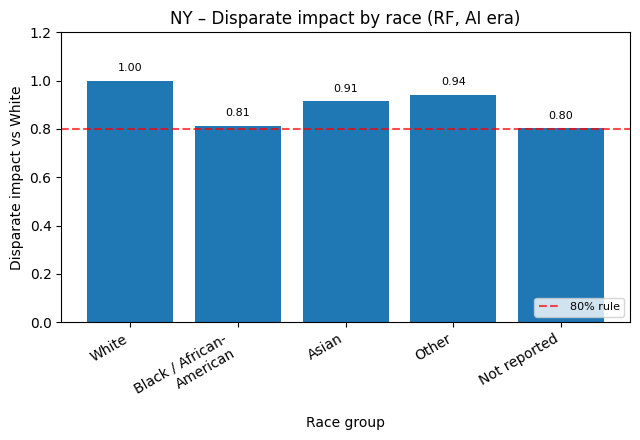

Fairness DI figure saved -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures_article\art_fig_nj_ia_di_by_race_rf.png


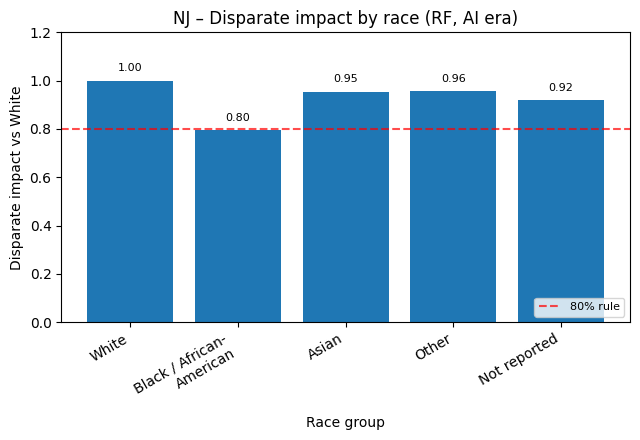

Fairness DI figure saved -> C:\Users\33669\OneDrive\Документы\data_credit_scoring\tri_state_ai\data_work\figures_article\art_fig_ct_ia_di_by_race_rf.png


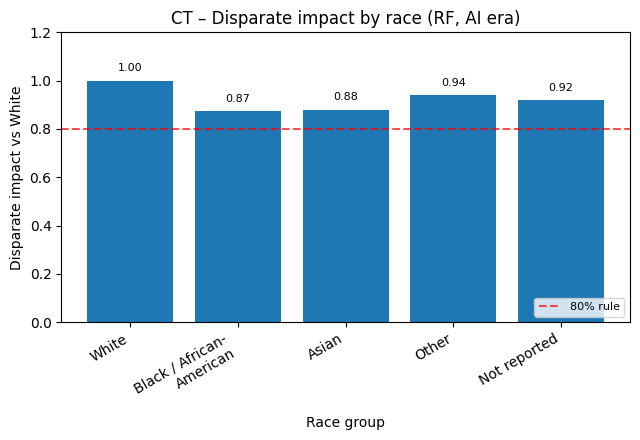

In [26]:
# %% [markdown]
# ============================================================
# BLOCK 5 – RQ4 (AI era): Extended RF fairness by state and race
# ============================================================
# - One global "structural" RF model on the full AI tri-state cohort
# - Fairness metrics by (state, race), normalized vs White within each state
# - Small groups (n < min_n) are dropped from the main table/figures
# ============================================================

# %% [code]
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, brier_score_loss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from textwrap import fill

# ---------------------------------------------------
# 0. Clean and aggregate race categories for fairness
# ---------------------------------------------------
race_clean_map = {
    "White": "White",
    "Black or African American": "Black / African-American",
    "Asian": "Asian",
    "Race Not Available": "Not reported",
    "Free Form Text Only": "Other",
    "Joint": "Other",
    "2 or more minority races": "Other",
    "American Indian or Alaska Native": "Other",
    "Native Hawaiian or Other Pacific Islander": "Other",
}

if "derived_race" in df_ia.columns:
    df_ia["derived_race"] = df_ia["derived_race"].replace(race_clean_map)

race_order_fair = [
    "White",
    "Black / African-American",
    "Asian",
    "Other",
    "Not reported",
]

# ---------------------------------------------------
# 1. Structural RF model on AI tri-state cohort
# ---------------------------------------------------
fair_ml_cols = ["loan_purpose", "loan_type", "hoepa_status", "state_code", "year", "approved"]
fair_ml_cols = [c for c in fair_ml_cols if c in df_ia.columns]

print("Columns used for RF fairness (AI tri-state):", fair_ml_cols)

fair_df = df_ia[fair_ml_cols + ["derived_race", "state_abbr"]].dropna(
    subset=["approved", "derived_race", "state_abbr"]
).copy()
fair_df["approved"] = fair_df["approved"].astype(int)

X_fair = pd.get_dummies(
    fair_df.drop(columns=["approved", "derived_race", "state_abbr"]),
    drop_first=True,
)
y_fair = fair_df["approved"].values

print("X_fair shape:", X_fair.shape, "| y_fair shape:", y_fair.shape)

rf_fair_global = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)
rf_fair_global.fit(X_fair, y_fair)

y_pred_fair = rf_fair_global.predict(X_fair)
y_proba_fair = rf_fair_global.predict_proba(X_fair)[:, 1]

fair_df["y_hat_rf"] = y_pred_fair
fair_df["p_hat_rf"] = y_proba_fair

print("Global RF fairness model trained on the AI tri-state cohort.")


# ---------------------------------------------------
# 2. Group-level metrics (same spirit as Chapter 4)
# ---------------------------------------------------
def group_stats(y_true, y_pred, y_proba, mask, min_n=50):
    """
    Confusion-matrix-based metrics + Brier score for a subgroup.
    Returns None if group size < min_n or confusion matrix is degenerate.
    """
    n = int(mask.sum())
    if n < min_n:
        return None

    y_g = y_true[mask]
    yhat_g = y_pred[mask]
    p_g = y_proba[mask]

    cm = confusion_matrix(y_g, yhat_g)
    if cm.shape != (2, 2):
        return None
    tn, fp, fn, tp = cm.ravel()

    total = tn + fp + fn + tp
    pp_rate = (tp + fp) / total if total > 0 else np.nan  # predicted positive rate
    tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan      # True Positive Rate
    fnr = fn / (tp + fn) if (tp + fn) > 0 else np.nan      # False Negative Rate
    ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan      # Positive Predictive Value

    try:
        calib = brier_score_loss(y_g, p_g)
    except Exception:
        calib = np.nan

    return {
        "n": n,
        "PP_rate": pp_rate,
        "TPR": tpr,
        "FNR": fnr,
        "PPV": ppv,
        "Calibration_Brier": calib,
    }


def fairness_by_state_and_race(fair_df: pd.DataFrame, states, min_n=150):
    """
    Extended fairness by (state, race), normalized vs White in each state.
    Only keeps (state, race) cells with n >= min_n and valid metrics.

    Output columns:
    - state, race_group, n
    - PP_rate, DisparateImpact_vs_White
    - TPR, EqualOpportunityDiff_vs_White
    - FNR, FNRDiff_vs_White
    - PPV, PredictiveParityDiff_vs_White
    - Calibration_Brier, CalibrationDiff_vs_White
    """
    rows = []
    y_true = fair_df["approved"].values
    y_pred = fair_df["y_hat_rf"].values
    y_proba = fair_df["p_hat_rf"].values

    for st in states:
        df_st = fair_df[fair_df["state_abbr"] == st].copy()
        if df_st.empty:
            continue

        races = df_st["derived_race"].dropna().unique()

        if "White" not in races:
            print(f"⚠️ White not present in {st} – cannot normalize fairness metrics.")
            continue

        # Reference: White
        mask_white = (fair_df["state_abbr"] == st) & (fair_df["derived_race"] == "White")
        stats_white = group_stats(y_true, y_pred, y_proba, mask_white.values, min_n=min_n)
        if stats_white is None or stats_white["PP_rate"] <= 0:
            print(f"⚠️ White group insufficient or PP_rate=0 in {st}.")
            continue

        for race in races:
            mask_grp = (fair_df["state_abbr"] == st) & (fair_df["derived_race"] == race)
            stats_g = group_stats(y_true, y_pred, y_proba, mask_grp.values, min_n=min_n)
            n_grp = int(mask_grp.sum())

            # If group too small or degenerate → skip it entirely (no NaN row)
            if stats_g is None:
                print(f"    -> Dropping (state={st}, race={race}) due to n={n_grp} < {min_n} or unstable metrics.")
                continue

            di = stats_g["PP_rate"] / stats_white["PP_rate"]
            eo_diff = stats_g["TPR"] - stats_white["TPR"]
            fnr_diff = stats_g["FNR"] - stats_white["FNR"]
            ppv_diff = stats_g["PPV"] - stats_white["PPV"]
            calib_diff = stats_g["Calibration_Brier"] - stats_white["Calibration_Brier"]

            rows.append(
                {
                    "state": st,
                    "race_group": race,
                    "n": stats_g["n"],
                    "PP_rate": stats_g["PP_rate"],
                    "DisparateImpact_vs_White": di,
                    "TPR": stats_g["TPR"],
                    "EqualOpportunityDiff_vs_White": eo_diff,
                    "FNR": stats_g["FNR"],
                    "FNRDiff_vs_White": fnr_diff,
                    "PPV": stats_g["PPV"],
                    "PredictiveParityDiff_vs_White": ppv_diff,
                    "Calibration_Brier": stats_g["Calibration_Brier"],
                    "CalibrationDiff_vs_White": calib_diff,
                }
            )

    return pd.DataFrame(rows)


# Main fairness table (only valid groups, no NaN fairness metrics)
fairness_state_race = fairness_by_state_and_race(fair_df, tri_states, min_n=150)

print("\n=== Article – Table 5: Extended RF fairness (AI era) by state and race (RQ4) ===")
display(fairness_state_race)

fairness_path = OUT_TABLES / "art_table_5_rq4_fairness_rf_by_state_and_race_ia.csv"
fairness_state_race.to_csv(fairness_path, index=False)
print("Table 5 saved to:", fairness_path)


# ---------------------------------------------------
# 3. Helper for nice DI plots
# ---------------------------------------------------
def format_labels(labels, width=14):
    return [fill(str(lab), width=width) for lab in labels]


def auto_barplot_DI(ax, categories, values, title, ylabel, filename):
    """
    Barplot for Disparate Impact by race:
    - Horizontal if many categories
    - 0.8 "80% rule" reference line
    - Clean labels and annotations
    """
    n = len(categories)
    horizontal = n > 6

    max_val = float(np.nanmax(values)) if len(values) > 0 else 1.0
    upper = max(1.2, max_val + 0.1)

    if horizontal:
        ax.barh(categories, values)
        ax.set_xlabel("Disparate impact vs White")
        ax.set_ylabel("")
        ax.set_title(title)
        ax.set_xlim(0, upper)

        ax.axvline(0.8, linestyle="--", color="red", alpha=0.7, label="80% rule")

        for i, v in enumerate(values):
            if np.isnan(v):
                continue
            ax.text(v + 0.02, i, f"{v:.2f}", va="center", fontsize=8)

        ax.legend(loc="lower right", fontsize=8)
        plt.tight_layout()

    else:
        ax.bar(categories, values)
        ax.set_ylabel(ylabel)
        ax.set_xlabel("Race group")
        ax.set_title(title)
        ax.set_ylim(0, upper)

        ax.axhline(0.8, linestyle="--", color="red", alpha=0.7, label="80% rule")

        for i, v in enumerate(values):
            if np.isnan(v):
                continue
            ax.text(i, v + 0.03, f"{v:.2f}", ha="center", va="bottom", fontsize=8)

        if n > 4:
            plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

        ax.legend(loc="lower right", fontsize=8)
        plt.tight_layout()

    fig_path = OUT_FIGS / filename
    plt.savefig(fig_path, dpi=300, bbox_inches="tight")
    print("Fairness DI figure saved ->", fig_path)
    plt.show()


# ---------------------------------------------------
# 4. Figures: Disparate Impact by race and state (AI, RF)
# ---------------------------------------------------
for st in tri_states:
    sub = fairness_state_race[fairness_state_race["state"] == st].copy()
    if sub.empty:
        continue

    # enforce race order where possible
    sub["race_group"] = pd.Categorical(sub["race_group"], categories=race_order_fair, ordered=True)
    sub = sub.sort_values("race_group")

    # drop any remaining NaN in DI (par sécurité)
    sub = sub.dropna(subset=["DisparateImpact_vs_White"])
    if sub.empty:
        continue

    labels = format_labels(sub["race_group"].tolist(), width=16)
    di_values = sub["DisparateImpact_vs_White"].values

    fig, ax = plt.subplots(figsize=(6.5, 4.5))
    auto_barplot_DI(
        ax=ax,
        categories=labels,
        values=di_values,
        title=f"{st} – Disparate impact by race (RF, AI era)",
        ylabel="Disparate impact vs White",
        filename=f"art_fig_{st.lower()}_ia_di_by_race_rf.png",
    )


## Fairness étendue en période IA : Disparate impact par race (RF, Tri-State)

Les trois figures de *Disparate Impact* (DI) comparent le **taux de décisions positives prédites** par le Random Forest pour chaque groupe racial à celui des emprunteurs blancs (référence : DI = 1).  
La ligne horizontale rouge à 0,8 matérialise la **“règle des 80 %”** : un groupe dont le DI descend durablement sous ce seuil peut être considéré comme défavorisé selon les standards réglementaires américains.

---

## New York (NY)

À New York, les ratios de DI se situent entre **0,80 et 0,95** :

- **White** : DI = **1,00** (référence)
- **Black / African-American** : DI ≈ **0,81**, juste au-dessus du seuil critique
- **Asian** : DI ≈ **0,91**, proche de la parité avec les Whites
- **Other** : DI ≈ **0,94**
- **Not reported** : DI ≈ **0,80**, au seuil minimal

**Interprétation** :  
Le modèle RF reproduit une **hiérarchie d’accès au crédit** où les emprunteurs noirs sont les plus proches du seuil de disparate impact, tandis que les groupes Asian et Other sont beaucoup plus proches des emprunteurs blancs.  
La catégorie *Not reported* est également défavorisée, ce qui peut refléter une auto-sélection ou un profil de risque particulier.

---

## New Jersey (NJ)

Dans le New Jersey, les contrastes sont encore plus marqués :

- **White** : DI = **1,00**
- **Black / African-American** : DI ≈ **0,80**, exactement au seuil de la règle des 80 %
- **Asian** : DI ≈ **0,95**
- **Other** : DI ≈ **0,96**
- **Not reported** : DI ≈ **0,92**

**Interprétation** :  
Le groupe noir est **le seul à se situer précisément au seuil réglementaire**, indiquant une exposition élevée au risque de disparate impact.  
Les groupes Asian, Other et Not reported présentent des DI supérieurs à 0,90, ce qui suggère une quasi-parité ou une légère sur-représentation des approbations par rapport aux Whites.

---

## Connecticut (CT)

Dans le Connecticut, tous les groupes restent au-dessus de 0,80, mais avec des écarts visibles :

- **White** : DI = **1,00**
- **Black / African-American** : DI ≈ **0,87**
- **Asian** : DI ≈ **0,88**
- **Other** : DI ≈ **0,94**
- **Not reported** : DI ≈ **0,92**

**Interprétation** :  
Les groupes Black et Asian affichent des DI entre 0,87 et 0,88 — soit une probabilité d’approbation environ **12–13 % inférieure** à celle des Whites.  
Les groupes Other et Not reported restent proches de la parité.

---

## Lecture synthétique des trois États

### 1. Absence de parité stricte entre groupes raciaux
Même avec un modèle RF structurel commun estimé sur l’ensemble du tri-state, les probabilités de décision ne sont **pas homogènes entre groupes raciaux**.  
Les DI des emprunteurs noirs restent systématiquement inférieurs à ceux des Whites (≈0,80 à ≈0,87).

### 2. Proximité du seuil réglementaire pour les emprunteurs noirs
À NY et NJ, les DI des emprunteurs noirs (≈0,80–0,81) **frôlent la limite de disparate impact**, indiquant une vulnérabilité réglementaire élevée.

### 3. Groupes asiatiques et “Other” plus avantagés
Les groupes Asian et Other (DI ≈0,88–0,96) obtiennent des probabilités d’acceptation très proches, voire légèrement supérieures, à celles des Whites dans plusieurs États.

### 4. Déficit marqué du groupe “Not reported”
Le DI (≈0,80–0,92) indique que **ne pas déclarer sa race n’est pas neutre** : ces ménages font face à des décisions positives moins fréquentes, suggérant un mécanisme de sélection non observé.

---

## Conclusion

L’utilisation d’un **modèle IA commun** ne neutralise pas les écarts raciaux d’accès au crédit.  
Même après contrôle pour les caractéristiques principales (type de prêt, but, HOEPA, État, année), les emprunteurs noirs demeurent proches ou en dessous du seuil des 80 % dans certaines juridictions.

Ces résultats justifient une exploration approfondie :

- des mécanismes de sélection,  
- des variables explicatives (proxies socio-économiques, géographie fine),  
- et des stratégies de mitigation du biais  
  (re-poids, contraintes de fairness, post-traitement des scores).

